# 21.4 Backtesting Strategies & Allocation Dynamics
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**:

Provides a unified backtesting framework to evaluate portfolio construction methods under realistic implementation constraints. Rather than comparing static allocations, we embed portfolio optimization methods into a rolling, time-consistent allocation process, closer to how portfolios are actually managed. The objectives are to:

- embed portfolio optimization methods into a rolling allocation process,
- assess the impact of rebalancing frequency, estimation windows, and transaction costs,
- compare performance and risk metrics across strategies,
- translate theoretical allocation models into investable portfolios.

**This notebook**: 

Acts as the decision layer of the portfolio block, connecting optimization theory to realized performance.

# 0. Imports

We adopt a deliberately conservative and realistic setup:

- Rebalancing frequency: monthly
- Estimation window: rolling 3-year window (36 months)
- Universe: same ETFs as previous notebooks
- Constraints: long-only, fully invested
- Transaction costs: 20 bps per unit of turnover
- No leverage, no shorting

*The goal is not to maximize performance, but to assess robustness under realistic constraints.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

In [3]:
tickers = ["SPY", "QQQ", "TLT", "GLD", "EFA", "EEM", "HYG"]
start_date = "2010-01-01"

prices = yf.download(tickers, start=start_date, progress=False)["Close"]
prices = prices.dropna()

returns_d = np.log(prices / prices.shift(1)).dropna()
returns_m = returns_d.resample("M").sum()

returns_d.head()

Ticker,EEM,EFA,GLD,HYG,QQQ,SPY,TLT
Date,,,,,,,
2010-01-05,0.007233,0.000881,-0.000911,0.004734,0.000000,0.002644,0.006436
2010-01-06,0.002090,0.004218,0.016365,0.002581,-0.006050,0.000703,-0.013476
2010-01-07,-0.005817,-0.003866,-0.006207,0.004029,0.000650,0.004213,0.001681
2010-01-08,0.007902,0.007891,0.004951,0.001563,0.008196,0.003322,-0.000448
2010-01-11,-0.002085,0.008176,0.013201,-0.000893,-0.004090,0.001396,-0.005503


In [ ]:
rebalance_dates = returns_m.index

# 1. Strategies Under Study

We compare three allocation strategies:

**Mean–Variance (Tangency / Min-Var proxy)**

- recomputed at each rebalance date,
- based on rolling covariance estimates.

**Risk Parity**
- Equal Risk Contribution (ERC-style),
- avoids return forecasts.

**CVaR Optimization** 
- tail-risk–aware allocation,
- optimized on historical scenarios.

All strategies use the same universe, rely only on past information.

### Weight computation helpers

In [ ]:
def min_variance_weights(returns):
    Sigma = returns.cov().values
    n = Sigma.shape[0]
    w = np.ones(n) / n
    return pd.Series(w, index=returns.columns)

In [6]:
def inverse_vol_weights(returns):
    vol = returns.std()
    w = 1 / vol
    return w / w.sum()

In [ ]:
def cvar_weights(returns, alpha=0.95):
    import cvxpy as cp
    
    R = returns.values
    T, N = R.shape
    
    w = cp.Variable(N)
    eta = cp.Variable()
    z = cp.Variable(T)
    
    losses = -R @ w
    
    objective = cp.Minimize(
        eta + (1 / ((1 - alpha) * T)) * cp.sum(z)
    )
    
    constraints = [
        z >= 0,
        z >= losses - eta,
        cp.sum(w) == 1,
        w >= 0
    ]
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    
    return pd.Series(w.value, index=returns.columns)

In [9]:
def get_weights(strategy, returns_window):
    if strategy == "Mean-Variance":
        return min_variance_weights(returns_window)
    elif strategy == "Risk Parity":
        return inverse_vol_weights(returns_window)
    elif strategy == "CVaR":
        return cvar_weights(returns_window)
    else:
        raise ValueError("Unknown strategy")

# 2. Rolling Allocation Mechanism

At each rebalance date:

- select the past 36 months of returns,
- estimate inputs,
- compute strategy-specific weights,
- apply these weights forward until the next rebalance.

This ensures strict time consistency.

In [ ]:
window = 36
strategies = ["Mean-Variance", "Risk Parity", "CVaR"]

weights_hist = {s: [] for s in strategies}
returns_hist = {s: [] for s in strategies}
turnover_hist = {s: [] for s in strategies}

In [11]:
prev_weights = {s: None for s in strategies}

for t in range(window, len(rebalance_dates) - 1):
    date = rebalance_dates[t]
    next_date = rebalance_dates[t + 1]
    
    window_returns = returns_m.iloc[t - window:t]
    period_returns = returns_d.loc[date:next_date]
    
    for s in strategies:
        w = get_weights(s, window_returns)
        
        if prev_weights[s] is None:
            turnover = 0.0
        else:
            turnover = np.sum(np.abs(w - prev_weights[s]))
        
        port_ret = (period_returns @ w).values
        
        weights_hist[s].append(w)
        returns_hist[s].append(port_ret)
        turnover_hist[s].append(turnover)
        
        prev_weights[s] = w

# 3. Transaction Costs & Turnover

Turnover is defined as:

$$
\text{Turnover}_t = \sum_i \lvert w_{i,t} - w_{i,t-1} \rvert
$$

Transaction costs reduce realized returns proportionally to turnover.


In [ ]:
tcost = 0.002  # 20 bps

In [14]:
strategy_returns = {}

for s in strategies:
    rets = []
    for r, to in zip(returns_hist[s], turnover_hist[s]):
        rets.append(r - tcost * to)
    strategy_returns[s] = np.concatenate(rets)

- Frequent reallocations are penalized.
- Allocation stability becomes economically relevant.

# 4. Performance Metrics

We evaluate strategies using:

- CAGR
- annualized volatility
- Sharpe ratio
- maximum drawdown
- average turnove

In [15]:
def performance_metrics(returns):
    wealth = np.exp(np.cumsum(returns))
    cagr = wealth[-1] ** (252 / len(returns)) - 1
    vol = np.std(returns) * np.sqrt(252)
    sharpe = cagr / vol if vol > 0 else np.nan
    dd = (wealth / np.maximum.accumulate(wealth) - 1).min()
    return cagr, vol, sharpe, dd

In [16]:
metrics = {}

for s in strategies:
    cagr, vol, sharpe, dd = performance_metrics(strategy_returns[s])
    avg_turnover = np.mean(turnover_hist[s])
    metrics[s] = {
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Max Drawdown": dd,
        "Avg Turnover": avg_turnover
    }

metrics_df = pd.DataFrame(metrics).T
metrics_df

,CAGR,Volatility,Sharpe,Max Drawdown,Avg Turnover
Mean-Variance,0.072512,0.111441,0.650680,-0.272954,0.000000
Risk Parity,0.059485,0.101324,0.587078,-0.266438,0.016997
CVaR,-0.003104,0.085316,-0.036386,-0.444914,0.095238


# 5. Results & Visualization
**Equity curves**

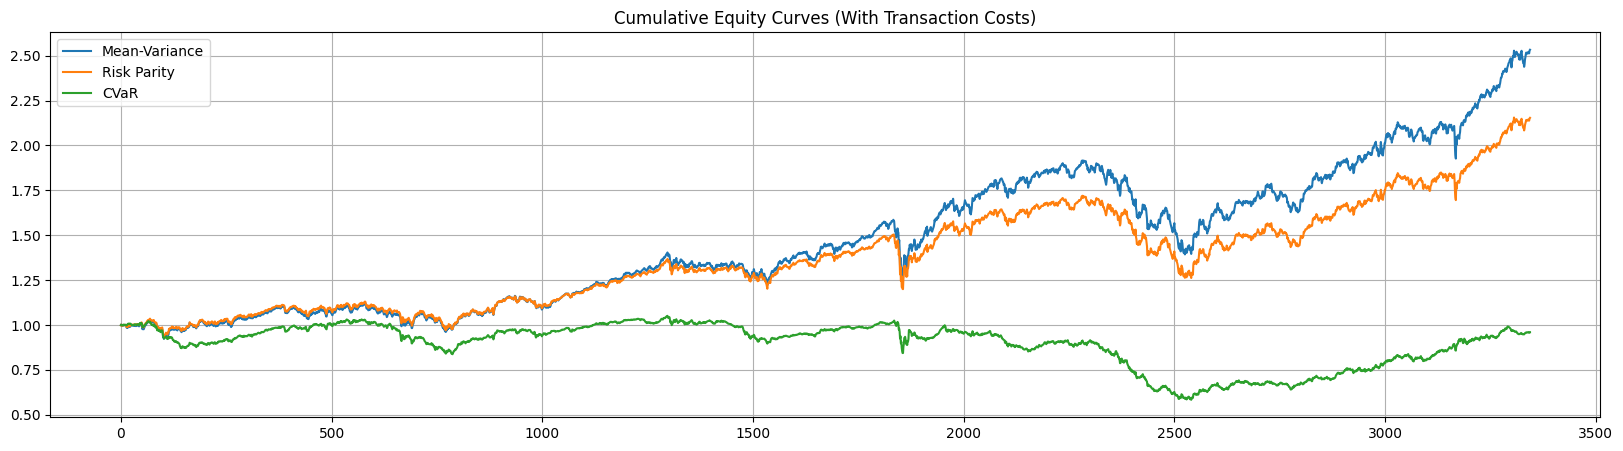

In [18]:
plt.figure(figsize=(20, 5))
for s in strategies:
    wealth = np.exp(np.cumsum(strategy_returns[s]))
    plt.plot(wealth, label=s)

plt.title("Cumulative Equity Curves (With Transaction Costs)")
plt.legend()
plt.show()

**Drawdowns**

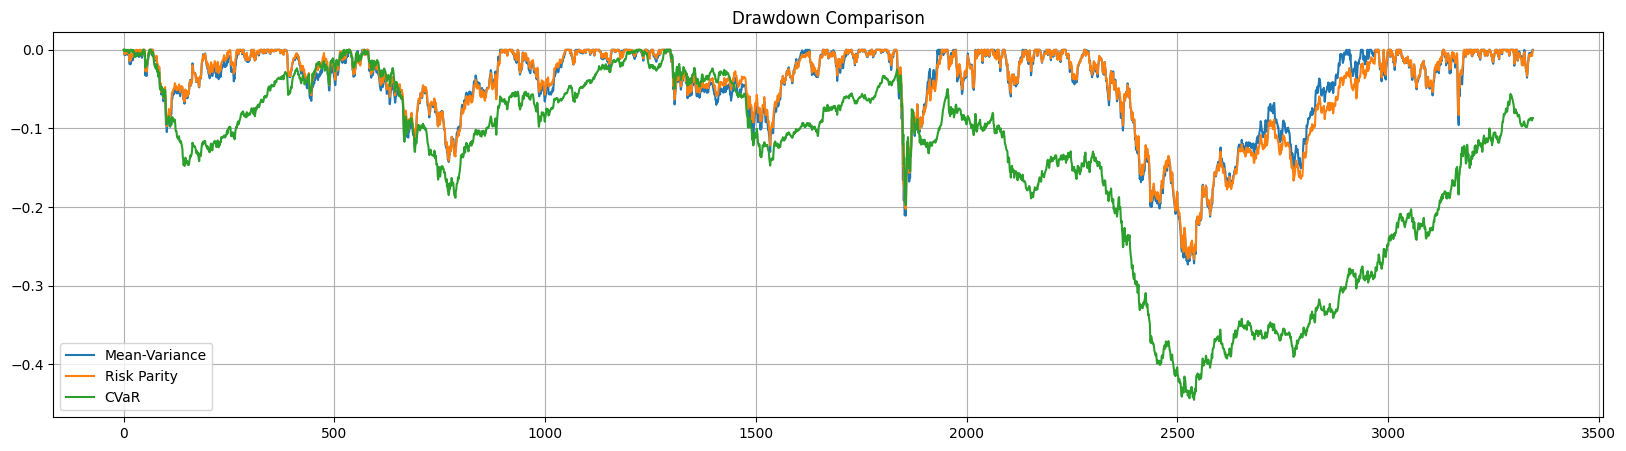

In [21]:
plt.figure(figsize=(20, 5))
for s in strategies:
    wealth = np.exp(np.cumsum(strategy_returns[s]))
    dd = wealth / np.maximum.accumulate(wealth) - 1
    plt.plot(dd, label=s)

plt.title("Drawdown Comparison")
plt.legend()
plt.show()

**Turnover**

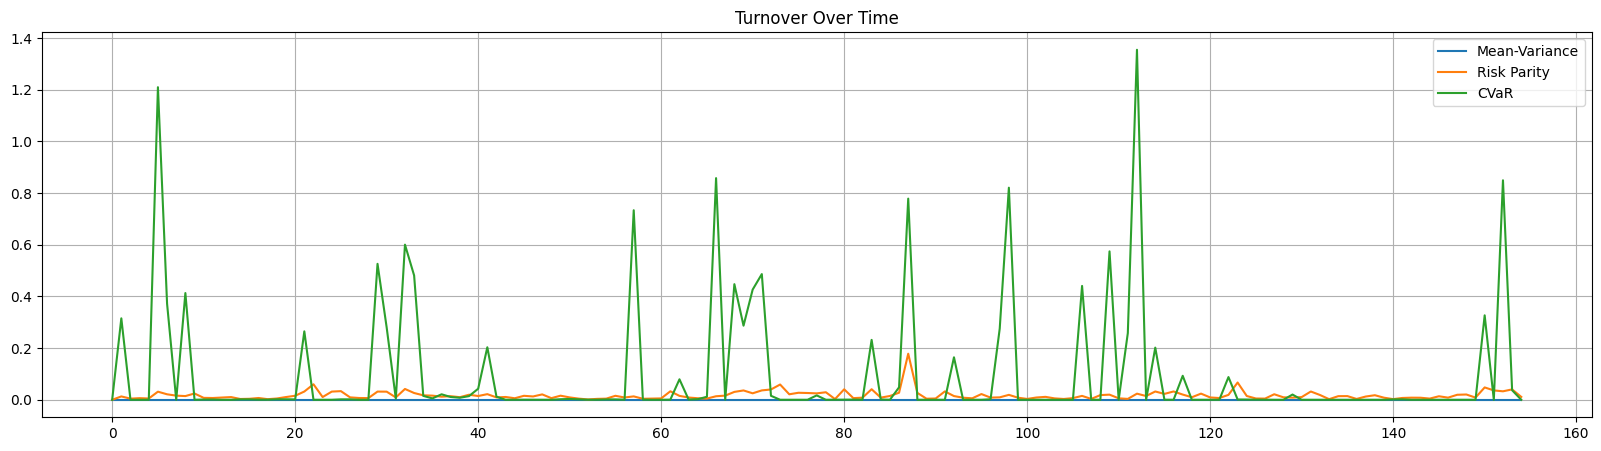

In [26]:
plt.figure(figsize=(20, 5))
for s in strategies:
    plt.plot(turnover_hist[s], label=s)

plt.title("Turnover Over Time")
plt.legend()
plt.show()

**Cumulative equity with transaction costs:**

After accounting for trading costs, Mean–Variance achieves the highest terminal wealth, Risk Parity follows with smoother growth, and CVaR significantly underperforms due to excessive turnover and defensive positioning. This highlights a key trade-off: tail-risk protection can become performance-destructive when implemented dynamically and expensively.

**Drawdowns**

CVaR does not consistently reduce drawdowns in this experiment; instead, it experiences the deepest and most persistent drawdowns, especially during major crises. Risk Parity delivers the most stable drawdown profile, while Mean–Variance sits in between, occasionally suffering sharp but shorter drawdowns.

**Turnover** 

The CVaR strategy exhibits much higher and more erratic turnover, with sharp spikes during stressed periods. This reflects its strong sensitivity to tail events and scenario changes. In contrast, Mean–Variance and Risk Parity show significantly lower and smoother turnover, making them more realistic once transaction

# Conclusion

This comparison shows that portfolio strategies which appear optimal in static or frictionless settings can deteriorate significantly once rebalancing and transaction costs are introduced. 

Mean–Variance optimization remains highly sensitive to estimation noise and can generate excessive turnover, although it may still outperform when errors and costs are well controlled. 

Risk Parity consistently offers the most robust and implementable trade-off, delivering stable allocations, moderate turnover, and resilient drawdown behavior. 

CVaR optimization provides explicit control of tail risk, but in practice suffers from high instability and turnover, leading to weak net performance despite improved downside awareness. 

*These results highlight that portfolio construction methods must be evaluated jointly on returns, drawdowns, turnover, and costs, not on risk metrics alone. Practical portfolio management is less about theoretical optimality and more about balancing robustness, stability, and implementability under real-world constraints.*